<img src="../img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">

<br><br><br>
<h2><font color="#00586D" size=4>Trabajo Fin de Máster</font></h2>

<h1><font color="#00586D" size=5>Análisis y Predicción de Resultados en Partidas de Clash Royale:<br><b>6. Explicabilidad</b></font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font><br>
</div>

<font color="#00586D" size=3>Iván Fernández García</font><br>
<font color="#00586D" size=3>Curso académico 2024/2025</font><br>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Interpretaciones globales](#section2)
    * [2.1. Permutación de características](#section2_1)
    * [2.2. *Partial Dependence Plots* (PDP) y *Individual Conditional Expectation* (ICE)](#section2_2)
    * [2.3. *SHapley Additive exPlanations* (SHAP)](#section2_3)
* [3. Interpretaciones locales](#section3)
    * [3.1. SHAP para muestras concretas](#section3_1)
    * [3.2. *Counterfactuals*](#section3_2)
* [4. Conclusiones](#section4)

---

In [23]:
import os
import sys
import joblib
import warnings
import pandas as pd
import shap
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

In [2]:
set_config(transform_output="pandas")
warnings.filterwarnings("ignore")
shap.initjs()

---

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>



La interpretabilidad de las predicciones es un componente esencial en proyectos de ciencia de datos, ya que en muchos casos tomamos decisiones importantes a través de un modelo "de caja negra" y necesitamos comprender el por qué de los resultados obtenidos para generar confianza en el sistema. En esta libreta exploraremos diferentes técnicas de explicabilidad aplicadas al modelo seleccionado tras la fase de modelado, tanto desde una perspectiva global (que busca comprender el comportamiento general del modelo) como local (centrada en cómo se generan predicciones para casos concretos).

El objetivo es responder a preguntas clave como:

* ¿Qué variables son más determinantes en la toma de decisiones del modelo?
* ¿Cómo afecta una característica determinada al resultado final?
* ¿Qué diferencias existen entre predicciones para distintas partidas?
* ¿Qué cambios serían necesarios para obtener una predicción distinta?

En el contexto del proyecto, podemos preguntarnos:

* ¿Cómo influyen los diferentes factores de *Clash Royale* en el desenlace de una partida?
* ¿Qué variables favorecen la victoria de un jugador? ¿Y la del otro?
* ¿Cuáles de estas pesan más y hacia qué lado se inclina la balanza?
* ¿Qué cambios (mazos, niveles, etc) serían necesarios para que, según el modelo, gane el otro jugador?

Lo primero que haremos será cargar el modelo e importar las funciones de preprocesamiento para poder utilizarlo.

In [3]:
sys.path.append(os.path.abspath(".."))

from preprocessing_functions import (
    create_diff_starting_trophies, create_diff_mean_card_level, create_diff_min_card_level, create_diff_max_card_level,
    create_diff_support_card_level, create_diff_total_star_level, create_diff_mean_elixir_cost, create_diff_num_evolution_cards,
    create_diff_num_win_condition_cards, create_diff_num_melee_cards, create_diff_num_ranged_cards, create_diff_num_air_cards,
    create_diff_num_anti_air_cards, create_diff_num_direct_damage_cards, create_diff_num_splash_damage_cards, create_diff_num_reset_attack_cards,
    create_diff_num_common_cards, create_diff_num_rare_cards, create_diff_num_epic_cards, create_diff_num_legendary_cards,
    create_diff_num_champion_cards, create_diff_num_troop_cards, create_diff_num_building_cards, create_diff_num_spell_cards,
    create_diff_num_counters, create_diff_num_uncountered_cards, create_win_condition_advantage, create_rarity_score, create_balance_score
)

model = joblib.load("../pipelines/models/model.joblib")

Trabajaremos con los datos de prueba. A partir de un estimador ajustado con los datos de entrenamiento, explicaremos el comportamiento de este sobre todo el conjunto de *test* y sobre muestras concretas.

In [4]:
target = "winner"
df_test = pd.read_csv("../data/final/test.csv", parse_dates=["battleTime"])
X_test, y_test = df_test.drop(columns=[target]), df_test[target]

Debemos tener en cuenta que realmente nuestro modelo es un `Pipeline` formado por otro con los pasos de preprocesamiento seguido de un clasificador. Los datos de entrada son diferentes a los que el estimador recibe, ya que en el proceso se crean, se descartan, se codifican y se estandarizan características. Para trabajar correctamente con los datos que el modelo ha utilizado para aprender, podemos hacer lo siguiente:

* Separar el preprocesamiento del estimador.
* Aplicar "manualmente" el método `transform` del *pipeline* de preprocesamiento.
* En lugar de utilizar el modelo y los datos originales, se usa el estimador y los datos transformados.

Esto es completamente lícito, ya que el comportamiento es equivalente. Cuando nuestro modelo quiere predecir datos que deben ser procesados por el estimador, el método `transform` se llama internamente para aplicar las transformaciones correspondientes en función de los datos de entrenamiento (al entrenar se llamó a `fit_transform`). Por lo tanto, predecir los datos originales con el modelo completo es lo mismo que preprocesar (siempre transformando sin ajustar de nuevo) y utilizar la salida para predecir directamente con el estimador. Eso sí, tendremos que tener en cuenta que los valores que aparecen son posteriores al escalado, por lo que es preferible enfocarnos en la tendencia y no tanto en los valores.

In [5]:
preprocessing = model.named_steps["preprocessing"]
estimator = model.named_steps["estimator"]
X_test_transformed = preprocessing.transform(X_test)
X_test_transformed.head()

,diff_meanCardLevel,diff_minCardLevel,diff_maxCardLevel,diff_supportCardLevel,diff_totalStarLevel,diff_meanElixirCost,diff_numEvolutionCards,diff_numWinConditionCards,diff_numMeleeCards,diff_numRangedCards,...,player2_hasTheLog,player2_hasTornado,player2_hasClone,player2_hasEarthquake,player2_hasBarbarianBarrel,player2_hasHealSpirit,player2_hasGiantSnowball,player2_hasRoyalDelivery,player2_hasVoid,player2_hasGoblinCurse
0,-0.794145,0.043748,-1.294880,-1.128312,-1.403056,-0.962465,0.849769,2.134325,-2.004616,-0.803220,...,0,0,0,0,0,0,0,0,0,0
1,-1.292958,-0.676481,-0.242069,-1.128312,-0.429829,0.578018,-0.173802,1.069667,-0.709311,0.651292,...,1,0,0,0,0,0,0,1,0,0
2,-0.129061,0.763977,-1.294880,-0.055942,0.932688,-0.277806,-0.173802,-1.059649,-0.061658,-1.530476,...,0,0,0,0,0,0,0,0,0,0
3,1.699921,0.763977,1.863553,1.016429,-0.040539,1.091513,0.849769,1.069667,-0.709311,-0.075964,...,0,0,0,0,0,0,0,0,0,0
4,-0.794145,-1.396709,-0.242069,-0.055942,-1.013766,-0.962465,0.849769,2.134325,-0.709311,1.378549,...,0,0,0,0,0,0,0,0,0,0


Durante todo el proceso, siempre tomaremos `player2` como la clase positiva.

---

<a id="section2"></a>
## <font color="#00586D"> 2. Interpretaciones globales</font>

Vamos a comenzar con técnicas que nos permitan explicar el comportamiento del modelo sobre todo el conjunto de prueba.

<a id="section2_1"></a>
### <font color="#00586D"> 2.1. Permutación de características</font>

La importancia por permutación consiste en medir cuánto se degrada el rendimiento del modelo cuando el valor de una variable se altera aleatoriamente. Si desordenar una característica produce un descenso significativo en la precisión, podemos concluir que esa variable es importante para las predicciones del modelo. Nos permite obtener un ranking claro de las variables más influyentes. Sin embargo, como limita su análisis a relaciones individuales, puede no capturar correctamente efectos de interacción entre variables.

Podemos utilizar `permutation_importance` de `sklearn.inspection`:

In [6]:
r = permutation_importance(estimator, X_test_transformed, y_test, n_repeats=100, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test_transformed.columns[i]} {r.importances_mean[i]:.6f} +/- {r.importances_std[i]:.6f}")

diff_meanCardLevel 0.043513 +/- 0.003182
player2_totalStarLevel 0.034535 +/- 0.002938
diff_numCounters 0.002931 +/- 0.001220
player2_minCardLevel 0.002306 +/- 0.000747
player2_supportCardName_Tower Princess 0.002095 +/- 0.000836
diff_numUncounteredCards 0.002050 +/- 0.000908
player2_numDirectDamageCards 0.001920 +/- 0.000720
player1_minCardLevel 0.001847 +/- 0.000650
player1_meanCardLevel 0.001556 +/- 0.000724
player1_numCounters 0.001539 +/- 0.000545
player2_hasSparky 0.001200 +/- 0.000320
player2_numRangedCards 0.000773 +/- 0.000297
player1_numSplashDamageCards 0.000745 +/- 0.000349
player1_hasMiniP.E.K.K.A 0.000725 +/- 0.000305
player2_hasGiant 0.000642 +/- 0.000237
player1_hasPrincess 0.000564 +/- 0.000237
player1_numLegendaryCards 0.000543 +/- 0.000216
player2_numWinConditionCards 0.000369 +/- 0.000158
player1_hasSkeletonDragons 0.000326 +/- 0.000098
player2_hasBomber 0.000247 +/- 0.000114
player1_supportCardName_Cannoneer 0.000230 +/- 0.000031
player1_hasGoblins 0.000160 +/- 0.00

Después de 100 repeticiones, observamos algunas de las variables más relevantes. Algunas coinciden con las que obtuvimos con *Random Forest* sobre el conjunto de entrenamiento durante el EDA, y también con las de los árboles de profundidad 1 utilizados como *baselines*. Es llamativo no sólo que variables individuales de un jugador estén por encima de las diferencias, sino también que la variable individual de un jugador aparezca y la del otro jugador no. Esto debería nivelarse con un conjunto de datos más grande.

<a id="section2_2"></a>
### <font color="#00586D"> 2.2. *Partial Dependence Plots* (PDP) y *Individual Conditional Expectation* (ICE)</font>

Los gráficos de dependencia parcial (PDP) muestran cómo varía la predicción media del modelo al modificar el valor de una o dos variables, manteniendo las demás constantes. Es una forma sencilla de visualizar la dirección y forma del efecto. En paralelo, los gráficos ICE (*Individual Conditional Expectation*) permiten observar ese mismo efecto a nivel de muestra individual. Esto resulta útil para detectar si el comportamiento del modelo varía mucho entre distintos individuos.

Juntos, PDP e ICE ofrecen una imagen más completa, combinando patrones generales y casos individuales.

Mostaremos diferentes gráficos utilizando algunas variables. Debemos recordar que estamos tomando `player2` como clase positiva, por lo que los valores positivos significan que el modelo tiende a predecir que gana el segundo jugador y los valores negativos que gana el primero.

Comenzamos con PDP + ICE para variables individuales:

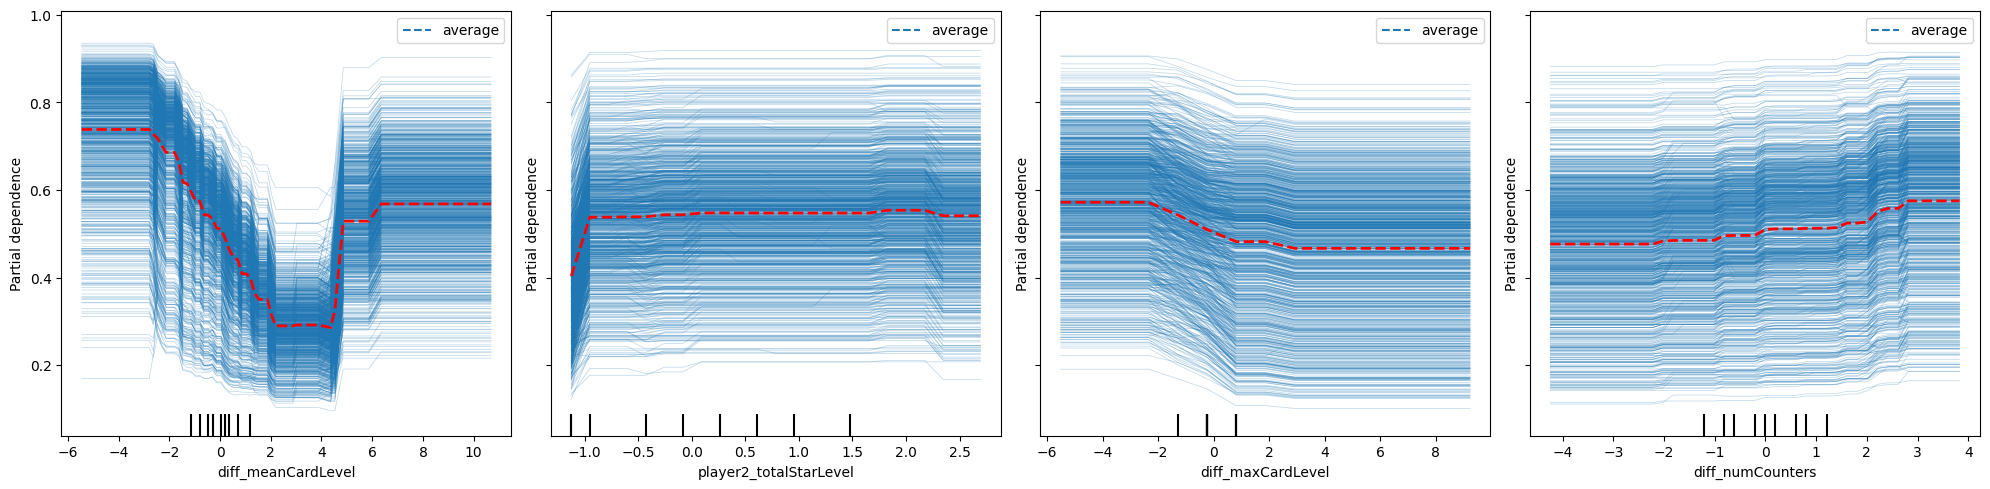

In [21]:
features = ["diff_meanCardLevel", "player2_totalStarLevel", "diff_maxCardLevel",  "diff_numCounters"]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

PartialDependenceDisplay.from_estimator(estimator=estimator, X=X_test_transformed, features=features, kind="both", ax=ax)

for axis in ax:
    for line in axis.get_lines():
        if "average" in line.get_label():
            line.set_color("red")
            line.set_linewidth(2)

plt.tight_layout()
plt.show()


Ahora vamos a utilizar estas variables por pares. En estos casos solamente podemos utilizar PDP (`kind="average"`):

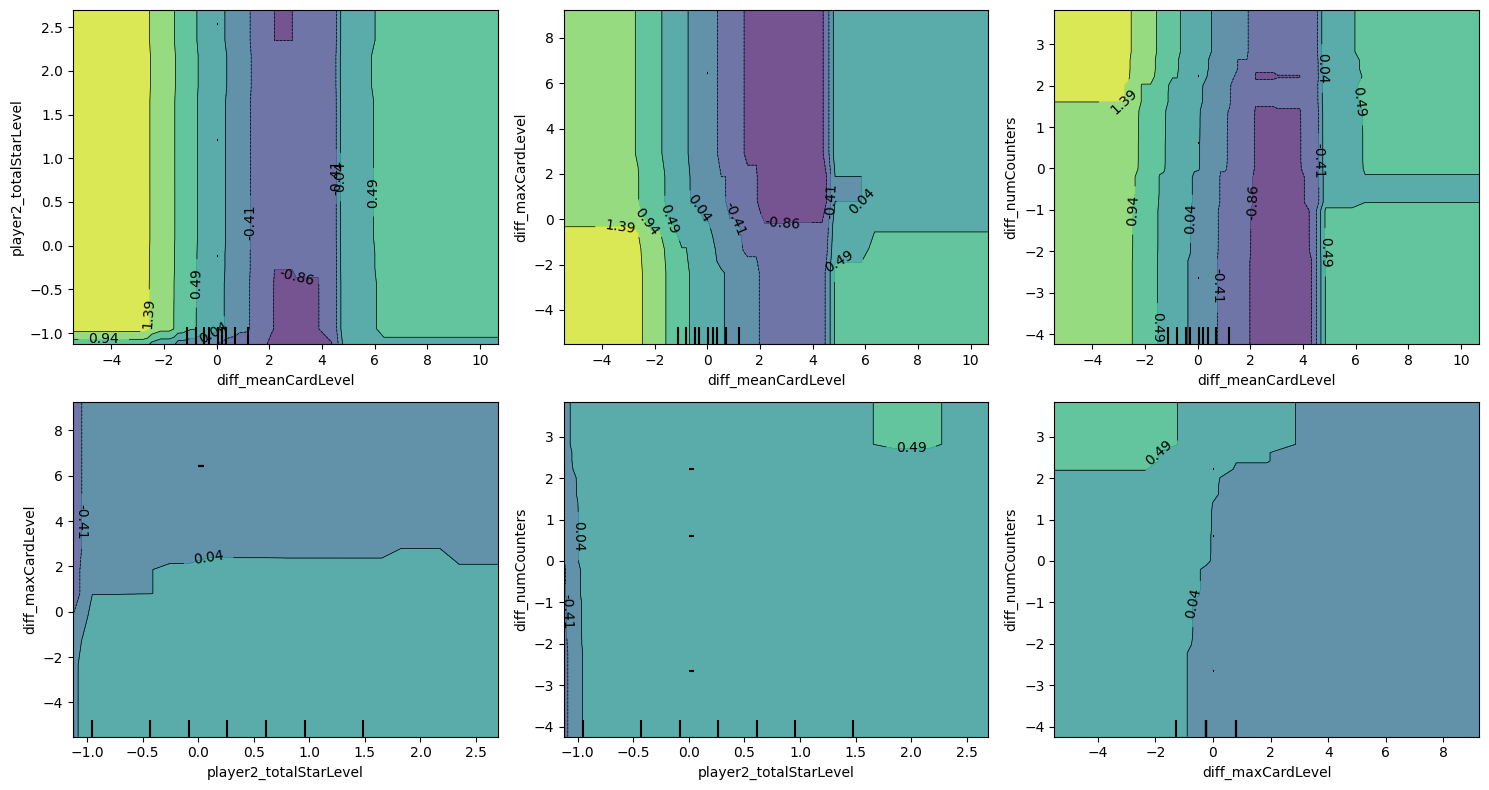

In [22]:
features = [
    ("diff_meanCardLevel", "player2_totalStarLevel"), ("diff_meanCardLevel", "diff_maxCardLevel"), ("diff_meanCardLevel", "diff_numCounters"),
    ("player2_totalStarLevel", "diff_maxCardLevel"), ("player2_totalStarLevel", "diff_numCounters"), ("diff_maxCardLevel", "diff_numCounters"),
]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

PartialDependenceDisplay.from_estimator(estimator=estimator, X=X_test_transformed, features=features, kind="average", ax=ax)

plt.tight_layout()
plt.show()


Esto nos permite comprender mejor cómo las relaciones entre pares de variables influyen en las predicciones. Por ejemplo, observamos que el hecho de que el modelo tienda a predecir como ganador un jugador con un nivel medio de las cartas muy superior es todavía más habitual cuando el nivel máximo también le favorece o cuando se tienen menos *counters* que el rival (es más fácil contrarrestarlo).

<a id="section2_3"></a>
### <font color="#00586D"> 2.3. *SHapley Additive exPlanations* (SHAP)</font>

Los valores SHAP se basan en un concepto de la teoría de juegos: las contribuciones individuales de cada “jugador” (variable) a una “ganancia” (predicción del modelo). Permiten descomponer cualquier predicción en una suma de aportes atribuibles a cada variable, con respecto a una media de referencia.

* Proveen un ranking claro de variables más influyentes.
* Indican si una variable contribuye a aumentar o reducir la predicción.
* Visualizan patrones de relación no lineales o dependencias entre variables.

Esto los convierte en una de las técnicas más robustas y detalladas disponibles para interpretabilidad global, permitiendo identificar tanto importancia como sentido y forma del impacto.

Comenzamos calculando los valores a partir de un explicador del conjunto de prueba con nuestro estimador:

In [9]:
explainer = shap.Explainer(estimator)
shap_values = explainer(X_test_transformed)

Vamos a mostrar un gráfico a modo de resumen. Este mide el impacto de las variables en las predicciones y utiliza el color para representar los valores de estas:

* Para cada variable, los puntos representan las muestras.
* El color de una muestra para una variable representa cómo de grande es su valor para esa variable (Menor > azul; Mayor > fucsia).
* La distribución en el eje horizontal representa el impacto en la predicción (Negativo > `player1`; Positivo > `player2`).

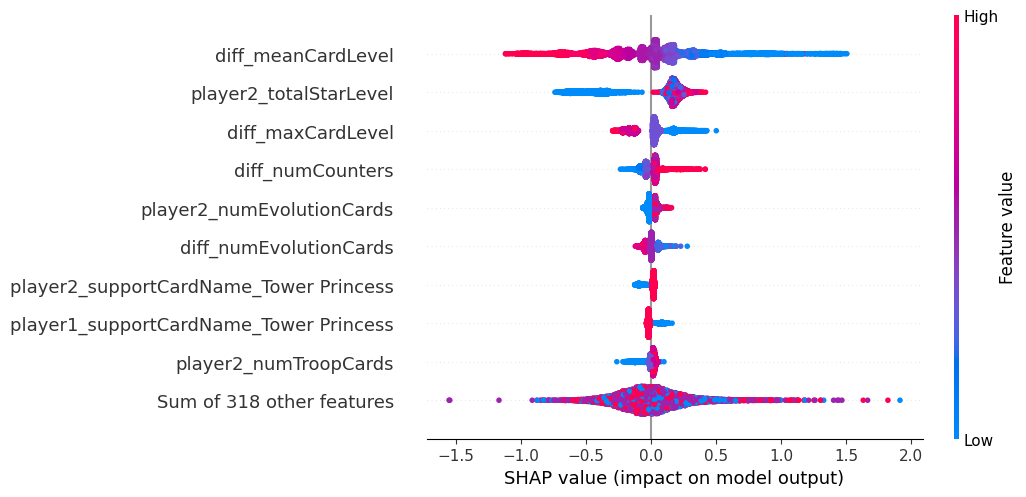

In [10]:
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()

Vemos que claramente la diferencia en el nivel de las cartas es el factor más determinante. Además, observamos una tendencia que se repite en el resto de diferencias. Lo que ocurre es que cuando la diferencia es menor (azul), significa que el segundo jugador tiene mayor nivel de cartas que el rival y tiende a ganar (valor SHAP positivo porque la clase positiva es `player2`). Cuando la diferencia es mayor (fucsia), significa que el primer jugador tiene mayor nivel de cartas que el rival y tiende a ganar (valor SHAP negativo). Con los *counters* ocurre lo mismo pero al revés.

Mediante el gráfico de barras observamos la importancia global de un modo más simple:

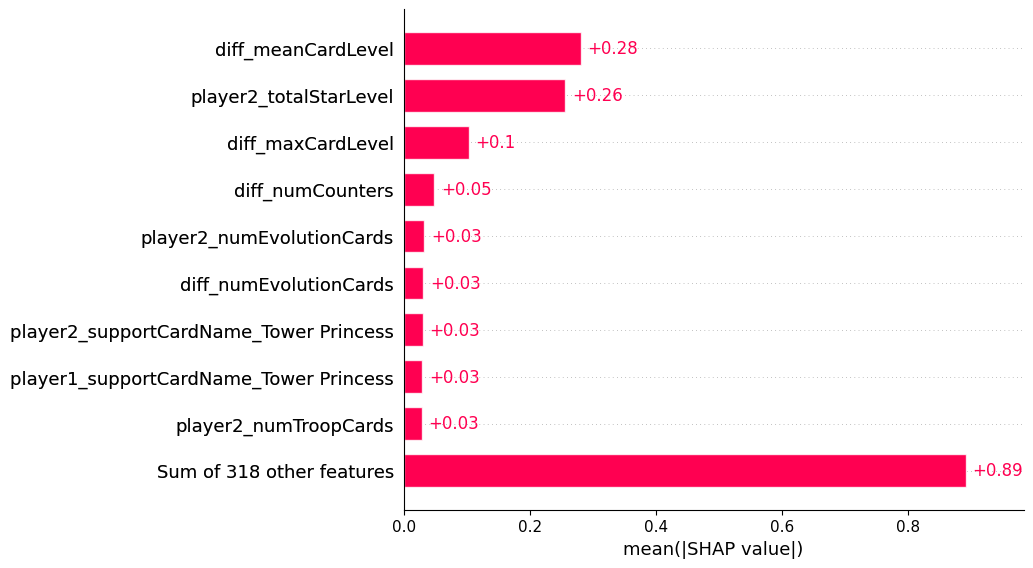

In [11]:
shap.plots.bar(shap_values, max_display=10)

Vamos a ver ahora la dependencia para algunas de las variables más importantes.

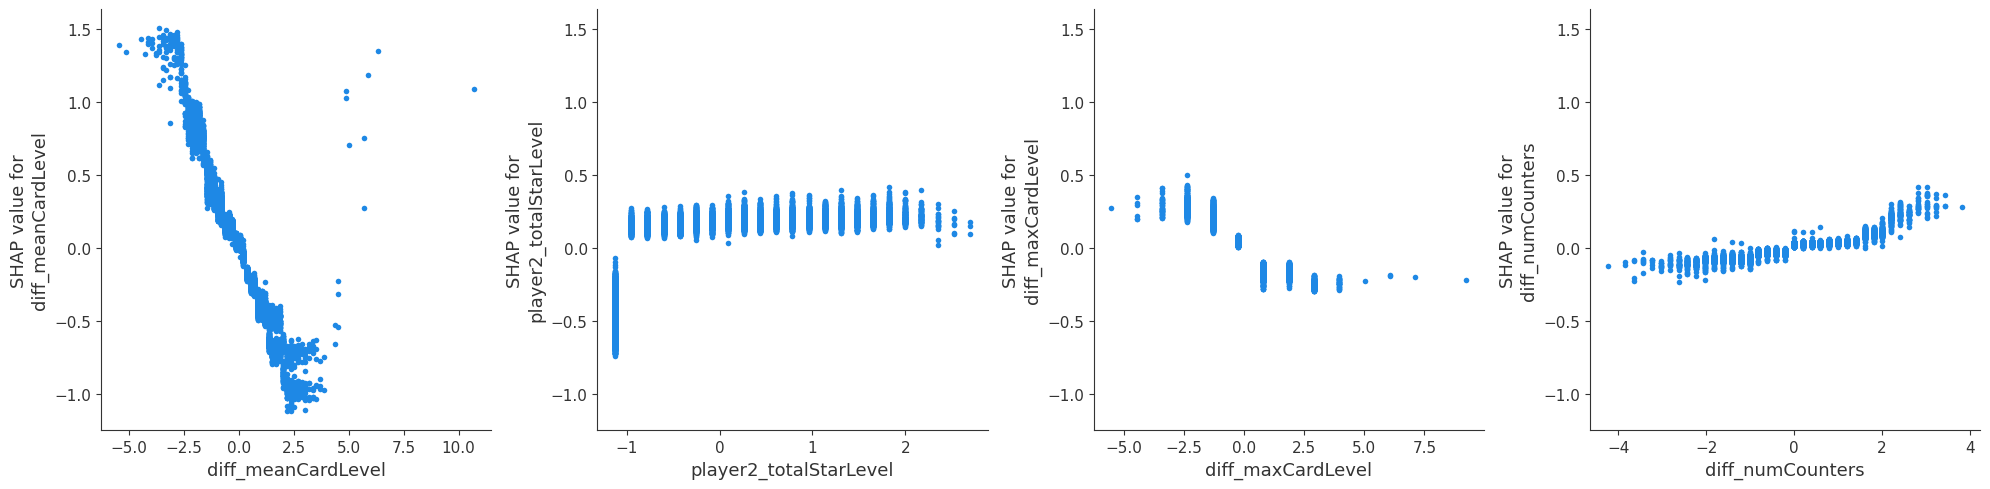

In [12]:
variables = ["diff_meanCardLevel", "player2_totalStarLevel", "diff_maxCardLevel", "diff_numCounters"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for var, ax in zip(variables, axes):
    shap.dependence_plot(var, shap_values.values, X_test_transformed, interaction_index=None, ax=ax, show=False)

plt.tight_layout()
plt.show()

* Para la diferencia en el nivel de las cartas, vemos una pendiente negativa que nos indica claramente que esta variable es altamente influyente en las predicciones.

* En el caso de los puntos estelares del segundo jugador, vemos que se tiende a predecir que gana el primer jugador cuando este es muy bajo.

* La diferencia en el nivel máximo también refleja que se tiende a predecir como ganador con más nivel máximo, pero de forma mucho menos exagerada que con el nivel medio.

* Para los *counters* observamos algo similar, aunque más suave. Además vemos que la tendencia es contraria, ya que es el jugador con un menor número de *counters* el que tiende a ganar.

---

<a id="section3"></a>
## <font color="#00586D"> 3. Interpretaciones locales</font>

Vamos a aplicar también alguna técnica para explicar muestras concretas. Utilizaremos ejemplos del conjunto de prueba.

<a id="section3_1"></a>
### <font color="#00586D"> 3.1. SHAP para muestras concretas</font>

Aplicado a un caso específico, SHAP permite explicar cómo cada característica ha influido en la predicción final. Cada variable se representa como una fuerza que empuja la predicción hacia una clase u otra. Este tipo de explicaciones es valioso en contextos donde se necesita justificar una decisión tomada por un modelo automatizado. Además, ayuda a detectar sesgos, errores o situaciones donde el modelo pueda estar confiando en señales inapropiadas.

Vamos a tomar dos muestras del conjunto de prueba, cada una con un ganador real distinto. Esta etiqueta no será utilizada, el objetivo es intentar predecir un ejemplo de cada.

In [13]:
x1 = X_test_transformed[y_test == "player1"].sample(1, random_state=42)
x2 = X_test_transformed[y_test == "player2"].sample(1, random_state=42)

explainer = shap.Explainer(estimator)
shap_values_x1 = explainer(x1)
shap_values_x2 = explainer(x2)

Las probabilidades para la primera muestra son las siguientes:

In [14]:
estimator.predict_proba(x1).flatten()

array([0.68598746, 0.31401254])

Vamos a ver cómo puede explicarse este resultado mediante gráficos de fuerza y cascada. Las variables en azul ayudan a predecir la clase negativa (favorecen la victoria de `player1`), mientras que las variables en fucsia ayudan a predecir la clase positiva (favorecen la victoria de `player2`). En este caso, vemos que los factores pesan más a favor del primer jugador.

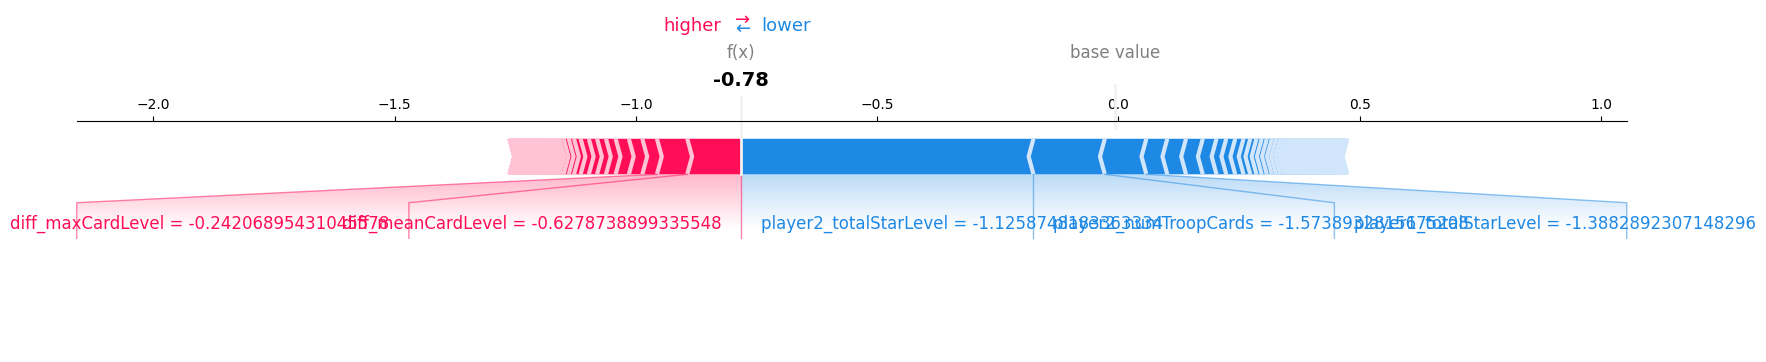

In [15]:
shap.force_plot(explainer.expected_value, shap_values_x1.values, x1, matplotlib=True)

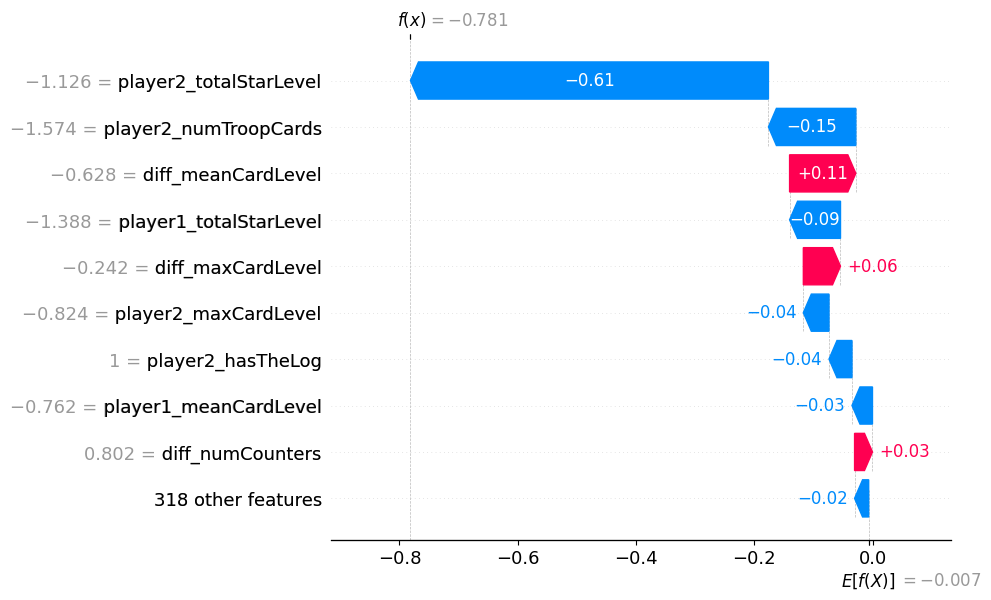

In [16]:
shap.plots.waterfall(shap_values_x1[0])

Para la segunda muestra, las probabilidades son muy ajustadas y el modelo acierta por muy poco:

In [17]:
estimator.predict_proba(x2).flatten()

array([0.49253778, 0.50746222])

En este caso, la diferencia en las condiciones que "empujan" hacia la victoria de cada jugador es mínima. También es importante comprender que no solo importa la cantidad, ya que es posible que haya varias características que favorezcan a una clase, pero que un número menor favorezca a la otra con más fuerza.

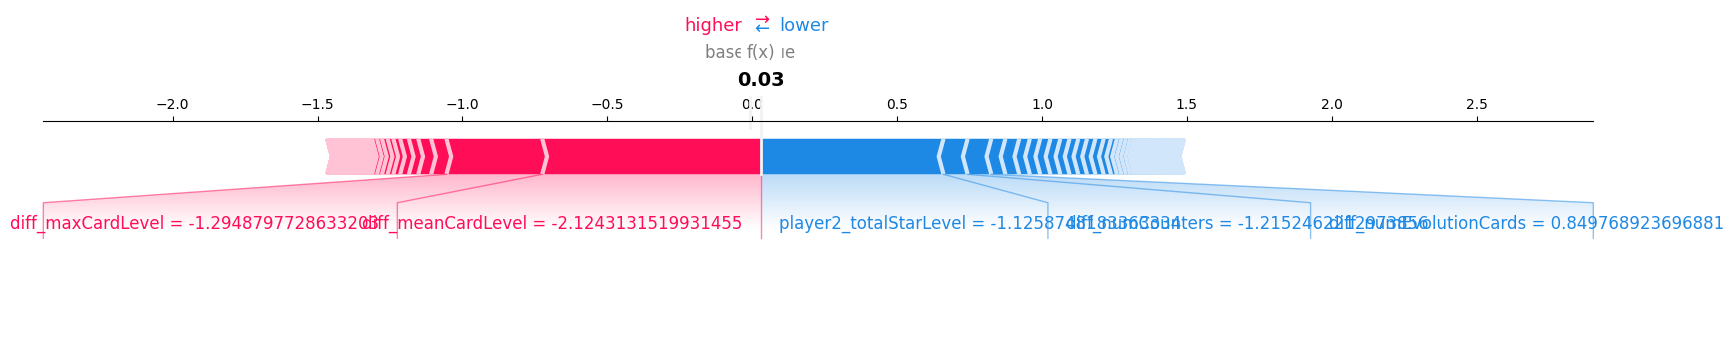

In [18]:
shap.force_plot(explainer.expected_value, shap_values_x2.values, x2, matplotlib=True)

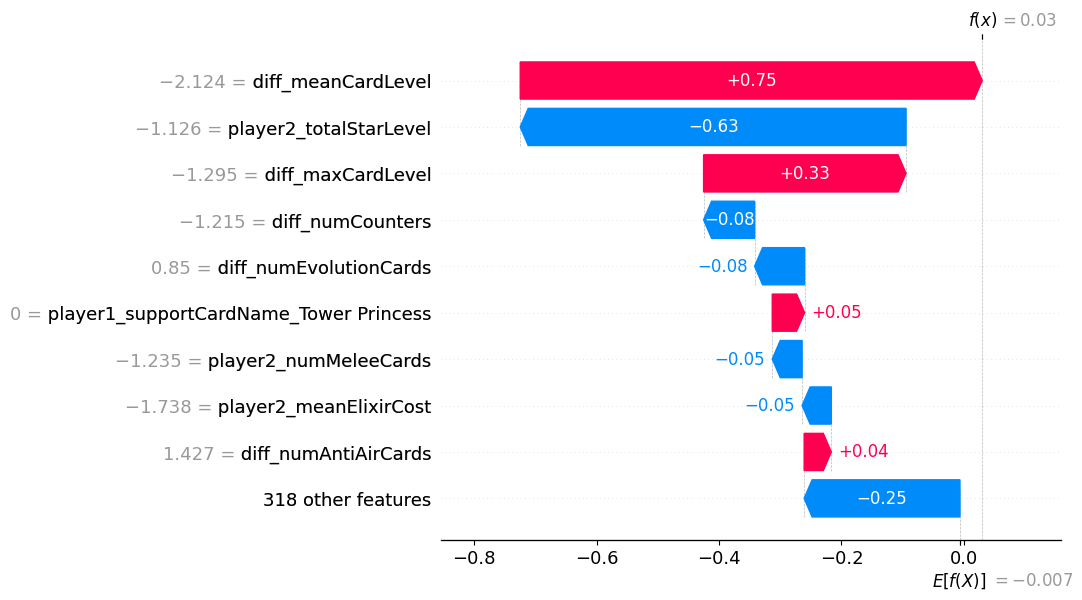

In [19]:
shap.plots.waterfall(shap_values_x2[0])

<a id="section3_2"></a>
### <font color="#00586D"> 3.2. *Counterfactuals*</font>

Las explicaciones contrafactuales plantean una pregunta distinta: ¿Qué tendría que haber sido diferente para que este caso fuera clasificado de otro modo? Por ejemplo, si un jugador fue predicho como perdedor, una explicación contrafactual podría indicar que con un nivel medio de cartas ligeramente superior, la predicción habría cambiado.

Estas explicaciones son especialmente útiles por su valor accionable. No se limitan a describir el por qué de una decisión, sino que informan qué condiciones podrían modificarse para alterar ese resultado. Se utilizan en contextos de mejora, recomendación o toma de decisiones interactivas.

No se va a incluir ningún ejemplo porque `DiCE`, que es compatible con *Scikit-learn*, requiere `pandas<2.0.0` y el resto del proyecto se ha realizado con la última versión por lo que el modelo deja de poder utilizarse.

---

<a id="section4"></a>
## <font color="#00586D"> 4. Conclusiones</font>

El uso de herramientas de explicabilidad ha permitido comprender en profundidad cómo el modelo toma decisiones. Se ha obtenido una visión clara de las variables más importantes y de cómo influyen en los resultados globales, así como en predicciones individuales. Estas últimas pueden ser integradas en la aplicación durante la fase de despliegue para interpretar nuevos casos introducidos por el usuario.

* La diferencia en el nivel medio de las cartas es un factor determinante en el resultado de las partidas.
* Si dejamos a un lado las variables más relevantes, la importancia está muy distruibuida entre el resto de características.
* Para nuestros datos, existen factores que son más relevantes para un jugador que para otro. Esto podría nivelarse con más datos.

Estos análisis no solo aumentan la confianza en el modelo, sino que también abren la puerta a una toma de decisiones más informada. Como futuras mejoras, se podrían incluir otras técnicas o realizar un análisis más profundo.

---